# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising, embed_with_offset

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler

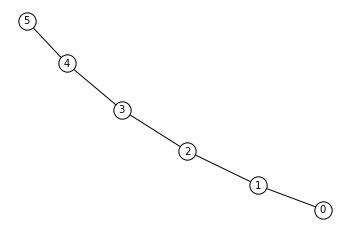

{'tag': 'NN(6)', 'total_vertices': 6, 'total_edges': 5, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2], [4, 5], [2, 3], [3, 4]], 'adjacency_hash': 'cb6075bc51cf31e074e89fe956468f6f'}
Greedy solution
 {0, 2, 4}
Chain strength: 4.0
B {0: [1082], 1: [1081, 953, 1085], 2: [1080, 952, 1087, 1095], 3: [964, 962, 834, 956], 4: [961, 833, 1089], 5: [835, 836], 6: [958, 954], 7: [1086], 8: [1083, 1084], 9: [965, 957], 10: [955, 959], 11: [1090, 1093], 12: [963, 966, 1091], 13: [839], 14: [838, 832], 15: [837]}
0
   0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  chain_break_fraction  \
0  0  1  0  0  1  0  0  0  0  0   0   0   0   0   0   0                   0.0   
9  0  1  1  0  0  1  0  1  0  1   0   0   0   0   0   0                   0.0   
8  0  1  1  0  1  0  0  1  0  1   0   1   0   0   0   0                   0.0   
7  0  1  0  1  0  1  0  0  0  1   0   0   0   1   0   0                   0.0   
6  1  0  1  0  0  1  0  1  0  0   0   0   0   0   0   0                   0.0   

   ene

In [10]:
# Define Adjacency matrix
# Hamming(d,q)
# Biparti
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
#graph, tag = gt.generate_hamming_graph(1, 2)
#graph, tag = gt.generate_bipartite_graph(3, 3)
#graph, tag = gt.generate_newman_watts_strogatz_graph(10, 4, 0.1)
# graph, tag = gt.generate_corona_graph(3,6)
for nvertices in range(0,1):
    graph, tag = gt.generate_nn_graph(6)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)

    G = nx.Graph()
    G.add_edges_from(graph)
    print("Greedy solution\n", dominating_set(G))
    
    # Experiment
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Initial")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")
    fact = 1 #max([maxJ, maxh/2]) * 1.2
    qubo = qubo / fact

    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Rescaled")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")

    # Set chain strength
    chain_strength = maxJ*2
    print(f"Chain strength: {chain_strength}")
    
    # DWave settings
    solver = "DW_2000Q_5"
    sampler = DWaveSampler(solver=solver)
    qubo_dict, embed, anneal_offsets = embed_with_offset(sampler=sampler, qubo=qubo, percentage=0.05, offset=True)

    dwave_config = {
        "annealing_time": 500,  # integer microseconds [1, 2000]
        "answer_mode": "histogram", # histogram or raw
        "auto_scale": True,
        "num_reads": 1000,  # raw will dump out all results
        "num_spin_reversal_transforms": 0,
        "readout_thermalization": 0, # default 0
        "programming_thermalization": 1000, # default 1000
        "chain_strength": chain_strength,
        "anneal_offsets": anneal_offsets
    }
    solver = "DW_2000Q_5"

    experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, chain_strength=chain_strength, qubo=qubo)


    # Solve on DWave and push to database
    for idx in range(1):
        print(idx)
        result = embed.sample_qubo(qubo_dict, **dwave_config)
        raw = result.to_pandas_dataframe()
        data_params = data_summary(raw, graph_params, experiment_params)
        #result = insert_result(graph_params, experiment_params, data_params)
    print(raw.sort_values("energy", ascending=True).head())

{(0, 1), (1, 2), (4, 7), (4, 5), (2, 3), (1, 6), (5, 0), (3, 4)}


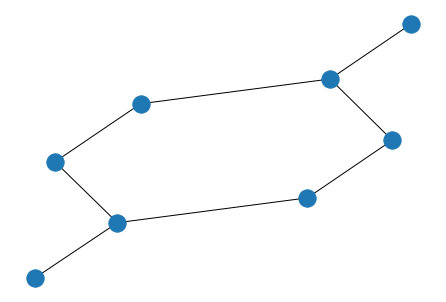

In [7]:
graph, _ = gt.generate_corona_graph(2,0)
print(graph)
G = nx.Graph()
G.add_edges_from(graph)
draw(G)